## DM-14762: Rerun complete HiTS 2015 data processing on the VC

This notebook makes some plots to investigate the results of running ap_pipe with new and improved templates.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import pandas as pd
import sqlite3
from astropy.time import Time

from lsst.daf.base import DateTime
import lsst.afw.image as afwImage
import lsst.daf.persistence as dafPersist
import lsst.geom

In [2]:
repo = '/project/mrawls/hits2015/rerun/newtemplate1'
butler = dafPersist.Butler(repo)

## Read the association database into pandas

In [3]:
sqliteFile = 'association.db'
connection = sqlite3.connect(os.path.join(repo, sqliteFile))

tables = {'obj': 'dia_objects', 'src': 'dia_sources', 'ccd': 'CcdVisit'}

objTable = pd.read_sql_query('select * from {0};'.format(tables['obj']), connection)
srcTable = pd.read_sql_query('select * from {0};'.format(tables['src']), connection)
ccdTable = pd.read_sql_query('select * from {0};'.format(tables['ccd']), connection)

connection.close()

## Make two "subsets" of sources on the sky, with a declination cut

This is legit because we know how the dataset is positioned on the sky a priori

In [4]:
dec_set1 = (objTable['coord_dec'] > -2)
dec_set2 = ~dec_set1

## Histogram of how many sources there are per object

<IPython.core.display.Javascript object>


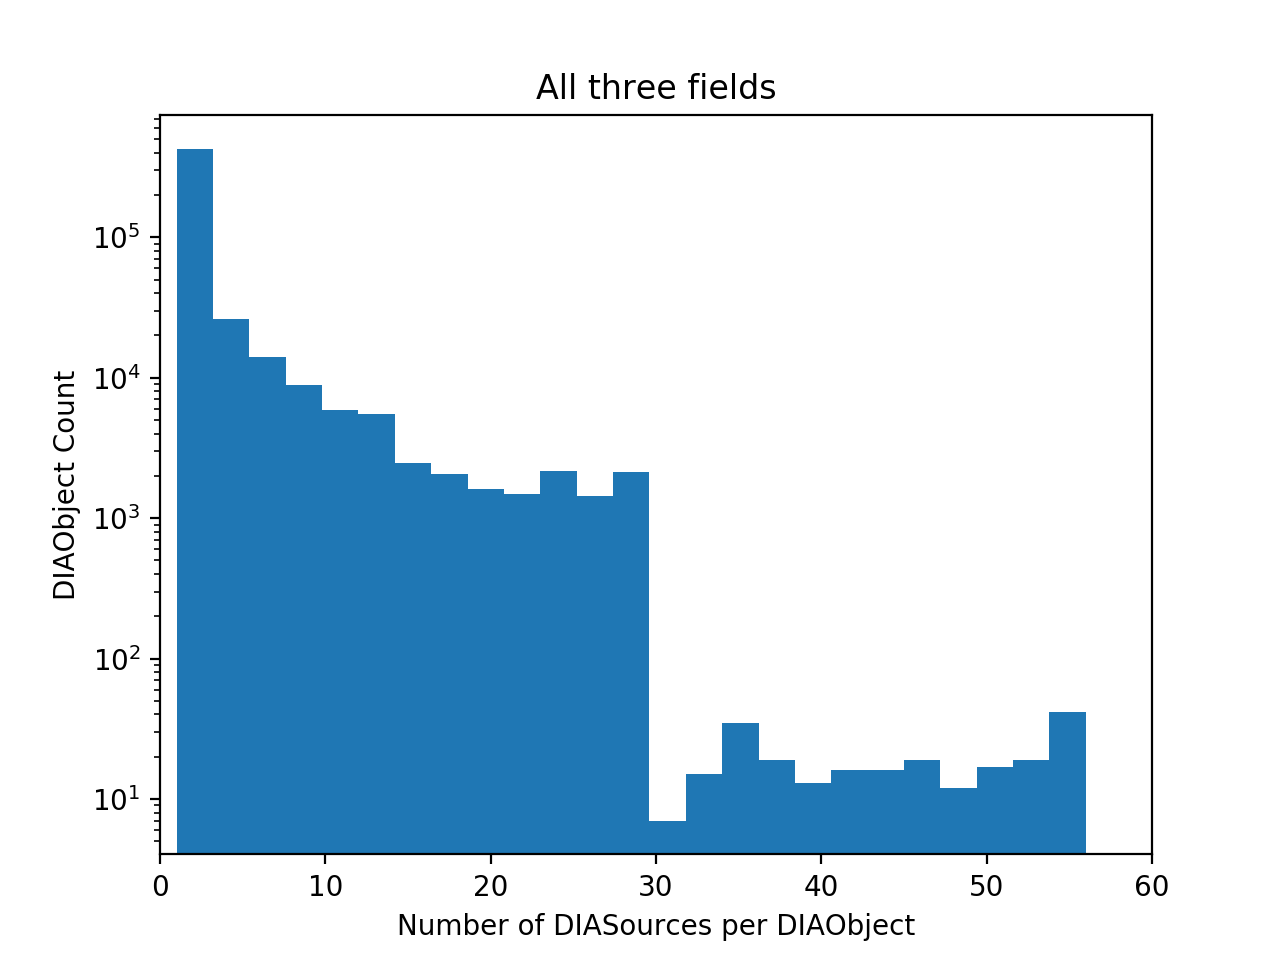

(0, 60)

In [5]:
count = objTable['nDiaSources'].values
plt.figure()
plt.hist(count, bins=25)
plt.yscale('log')
plt.xlabel('Number of DIASources per DIAObject')
plt.ylabel('DIAObject Count')
plt.title('All three fields')
plt.gca().set_xlim([0, 60])

<IPython.core.display.Javascript object>


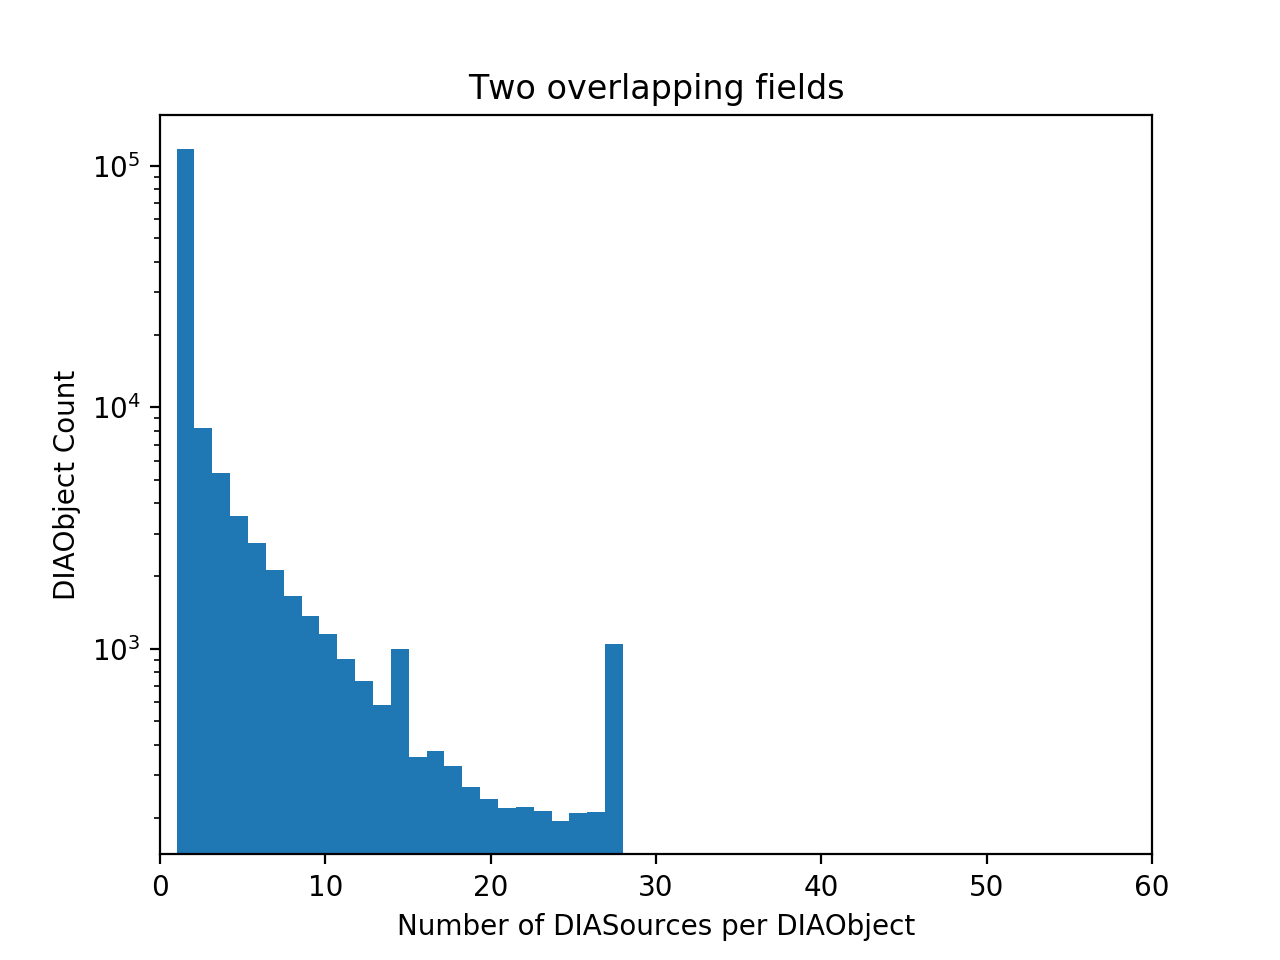

(0, 60)

In [6]:
count = objTable.loc[dec_set1, 'nDiaSources'].values
plt.figure()
plt.hist(count, bins=25)
plt.yscale('log')
plt.xlabel('Number of DIASources per DIAObject')
plt.ylabel('DIAObject Count')
plt.title('Two overlapping fields')
plt.gca().set_xlim([0, 60])

<IPython.core.display.Javascript object>


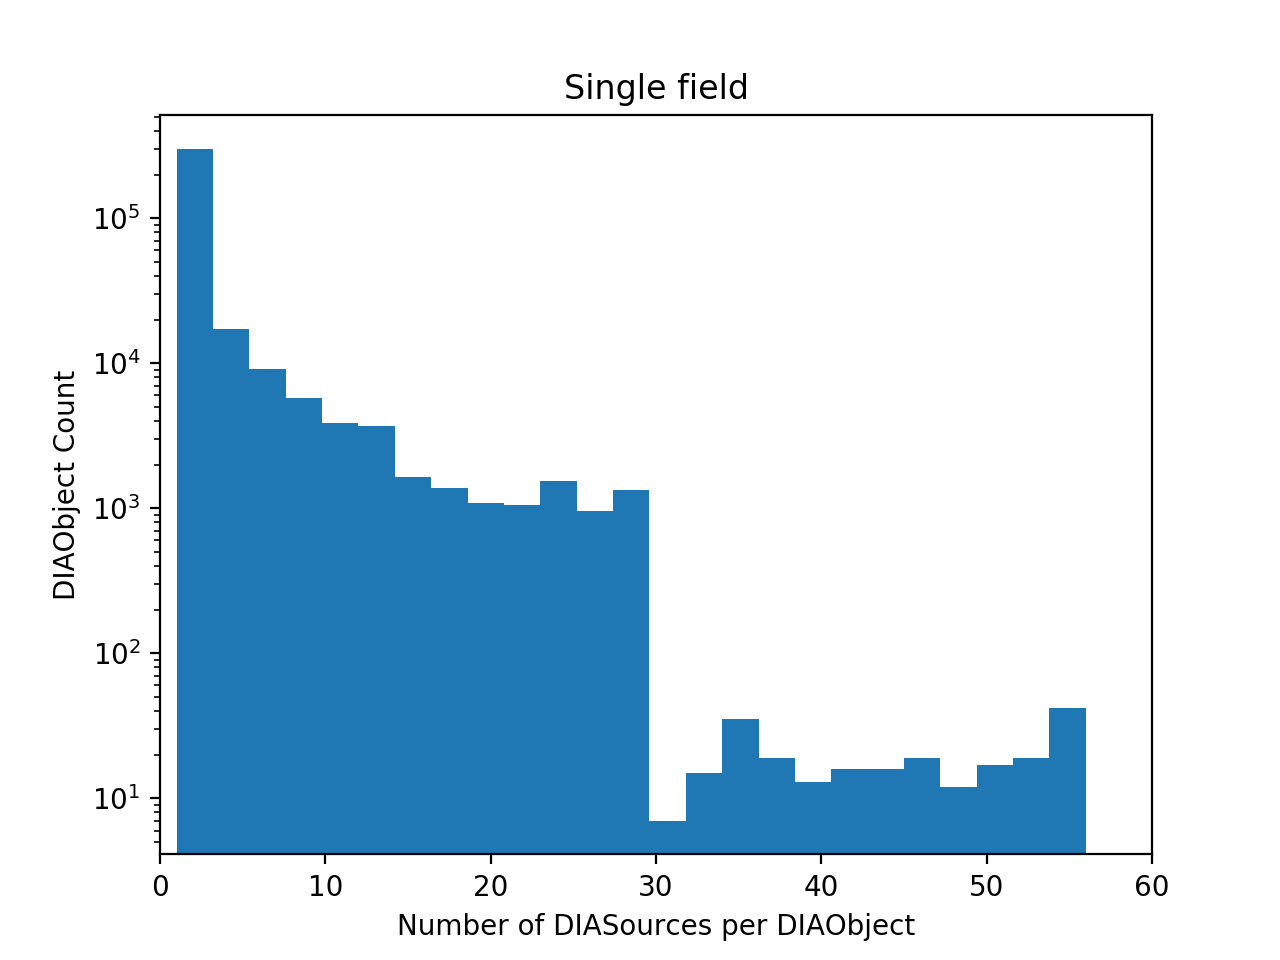

(0, 60)

In [7]:
count = objTable.loc[dec_set2, 'nDiaSources'].values
plt.figure()
plt.hist(count, bins=25)
plt.yscale('log')
plt.xlabel('Number of DIASources per DIAObject')
plt.ylabel('DIAObject Count')
plt.title('Single field')
plt.gca().set_xlim([0, 60])

## Visualizing the objects on the sky, colored and sized by number of sources

<IPython.core.display.Javascript object>


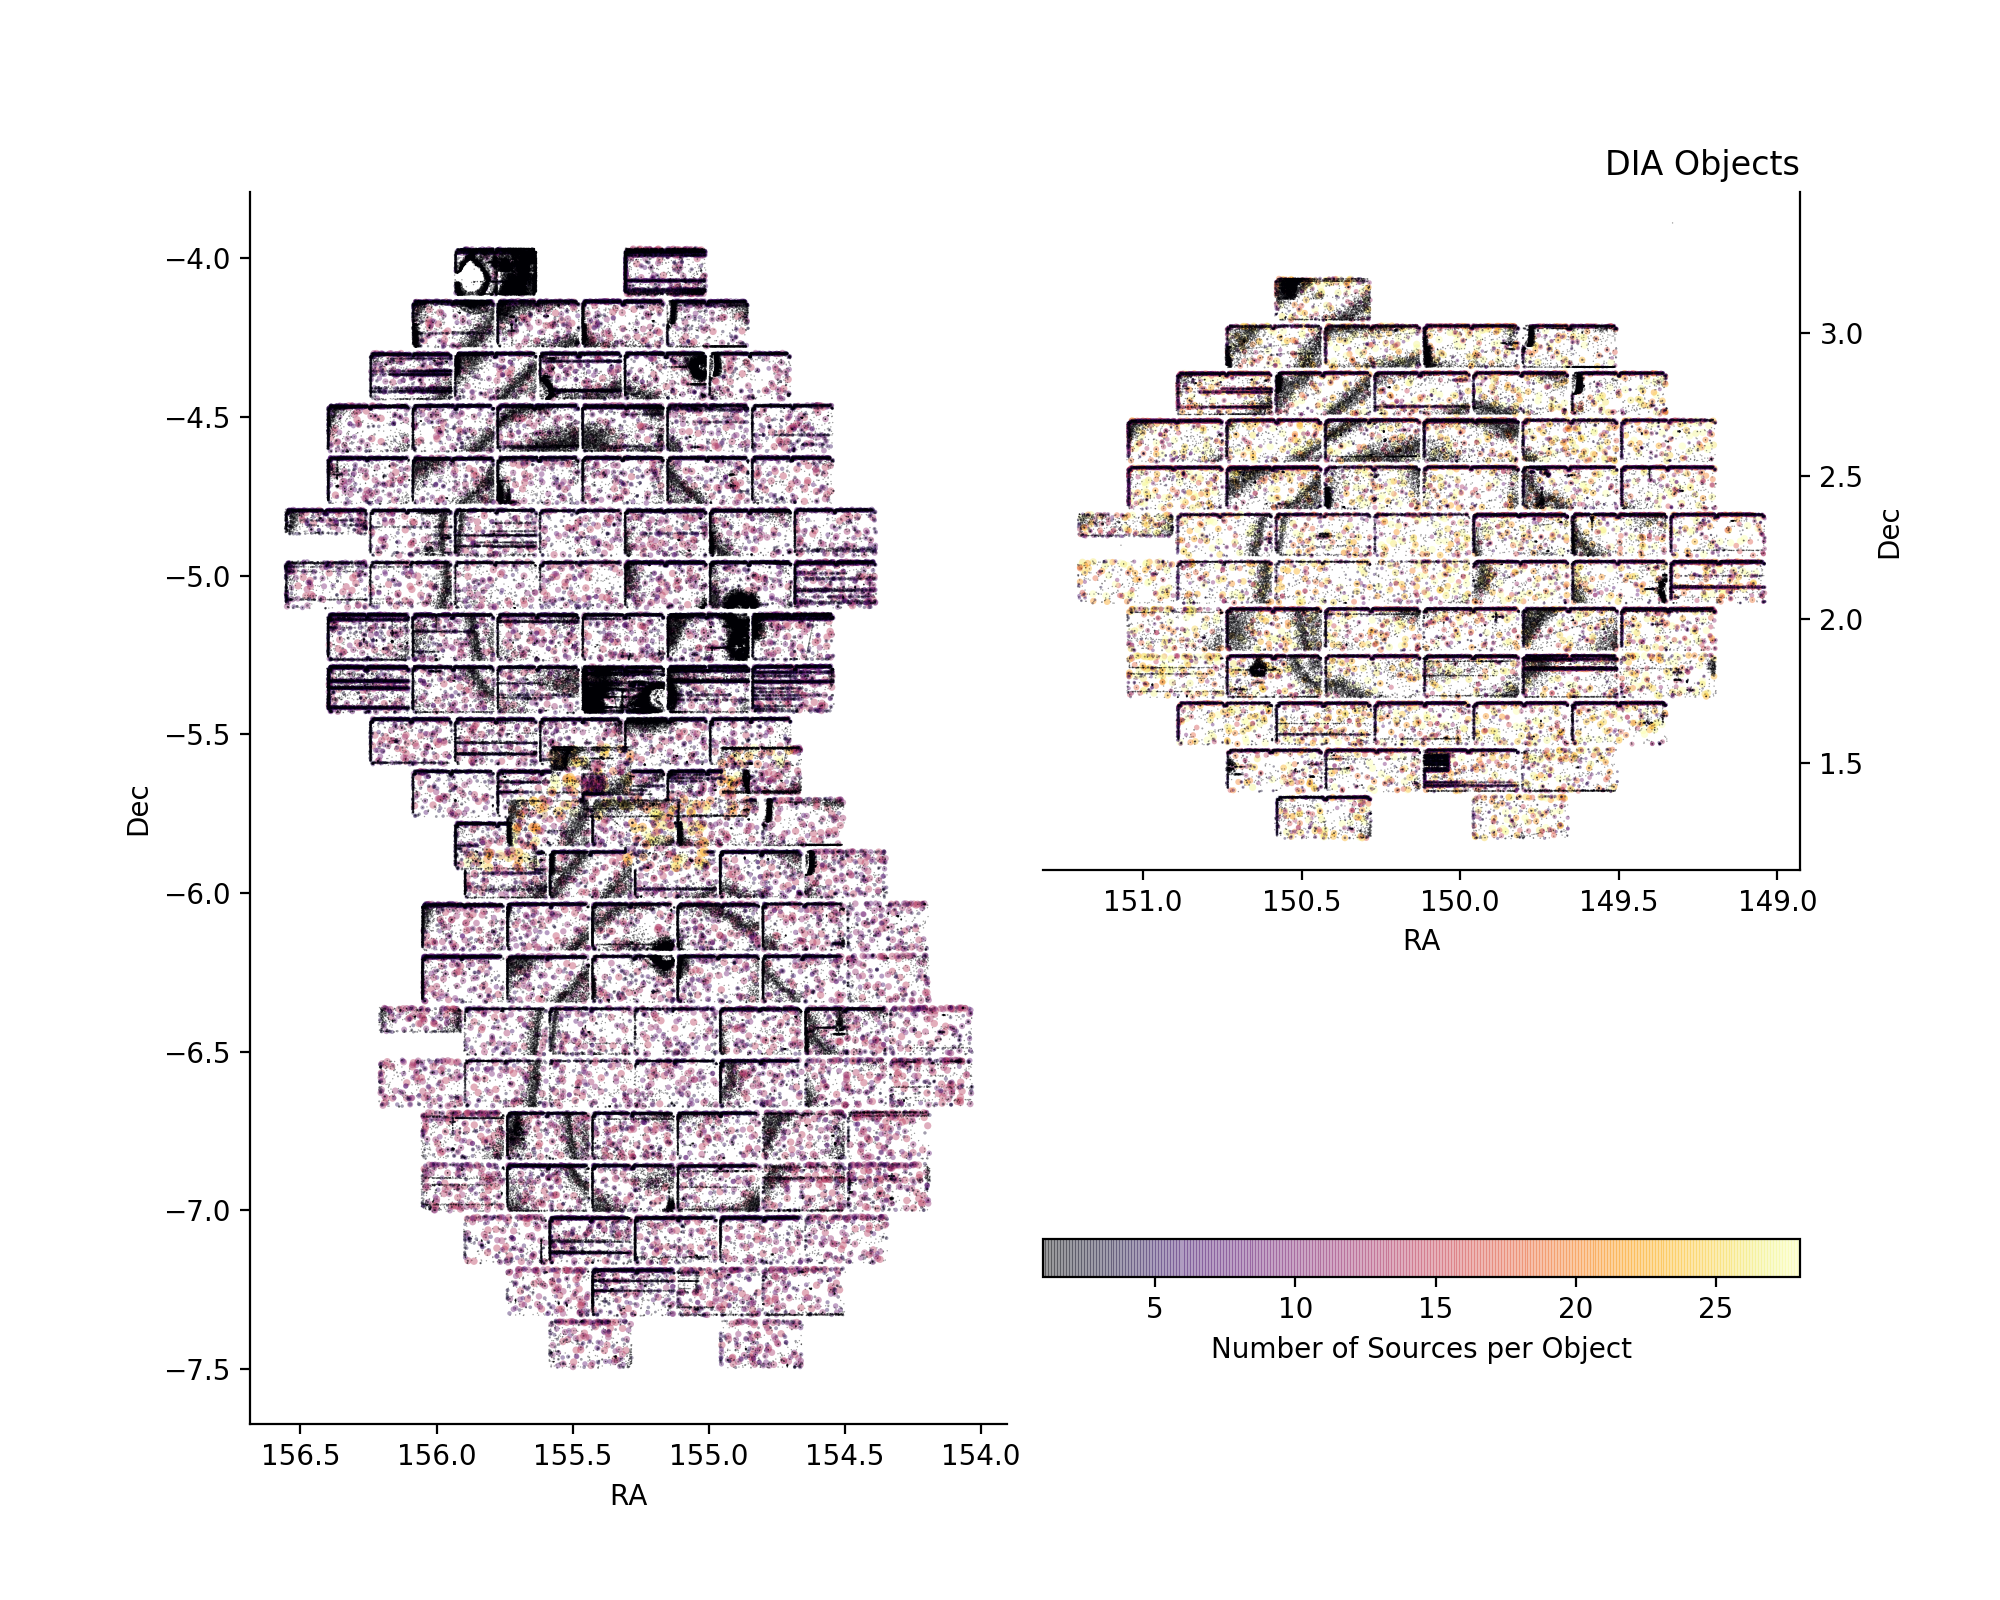

In [8]:
fig = plt.figure(facecolor='white', figsize=(10,8))
plt.subplots_adjust(wspace=0.1, hspace=0)

# Panel 1: one HiTS field
ax1 = plt.subplot2grid((4,4), (0,2), rowspan=4, colspan=2)
ax1.set_facecolor('white')
plot1 = ax1.scatter(objTable.loc[dec_set1, 'coord_ra'], objTable.loc[dec_set1, 'coord_dec'], marker='.',
                  lw=0, s=objTable.loc[dec_set1, 'nDiaSources'], c=objTable.loc[dec_set1, 'nDiaSources'],
                  alpha=0.4, cmap='inferno')
plt.title('DIA Objects', loc='right')
plt.xlabel('RA')
plt.ylabel('Dec')
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position('right')
ax1.invert_xaxis()  # RA should increase to the left
cb = fig.colorbar(plot1, orientation='horizontal', pad=0.3)
cb.set_label('Number of Sources per Object')

# Panel 2: two (overlapping) HiTS fields
ax2 = plt.subplot2grid((4,4), (0,0), rowspan=4, colspan=2)
ax2.set_facecolor('white')
plot2 = ax2.scatter(objTable.loc[dec_set2, 'coord_ra'], objTable.loc[dec_set2, 'coord_dec'], marker='.',
                  lw=0, s=objTable.loc[dec_set2, 'nDiaSources'], c=objTable.loc[dec_set2, 'nDiaSources'],
                  alpha=0.4, cmap='inferno')
plt.xlabel('RA')
plt.ylabel('Dec')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.invert_xaxis()

## Zoom on the overlap region of the two fields

<IPython.core.display.Javascript object>


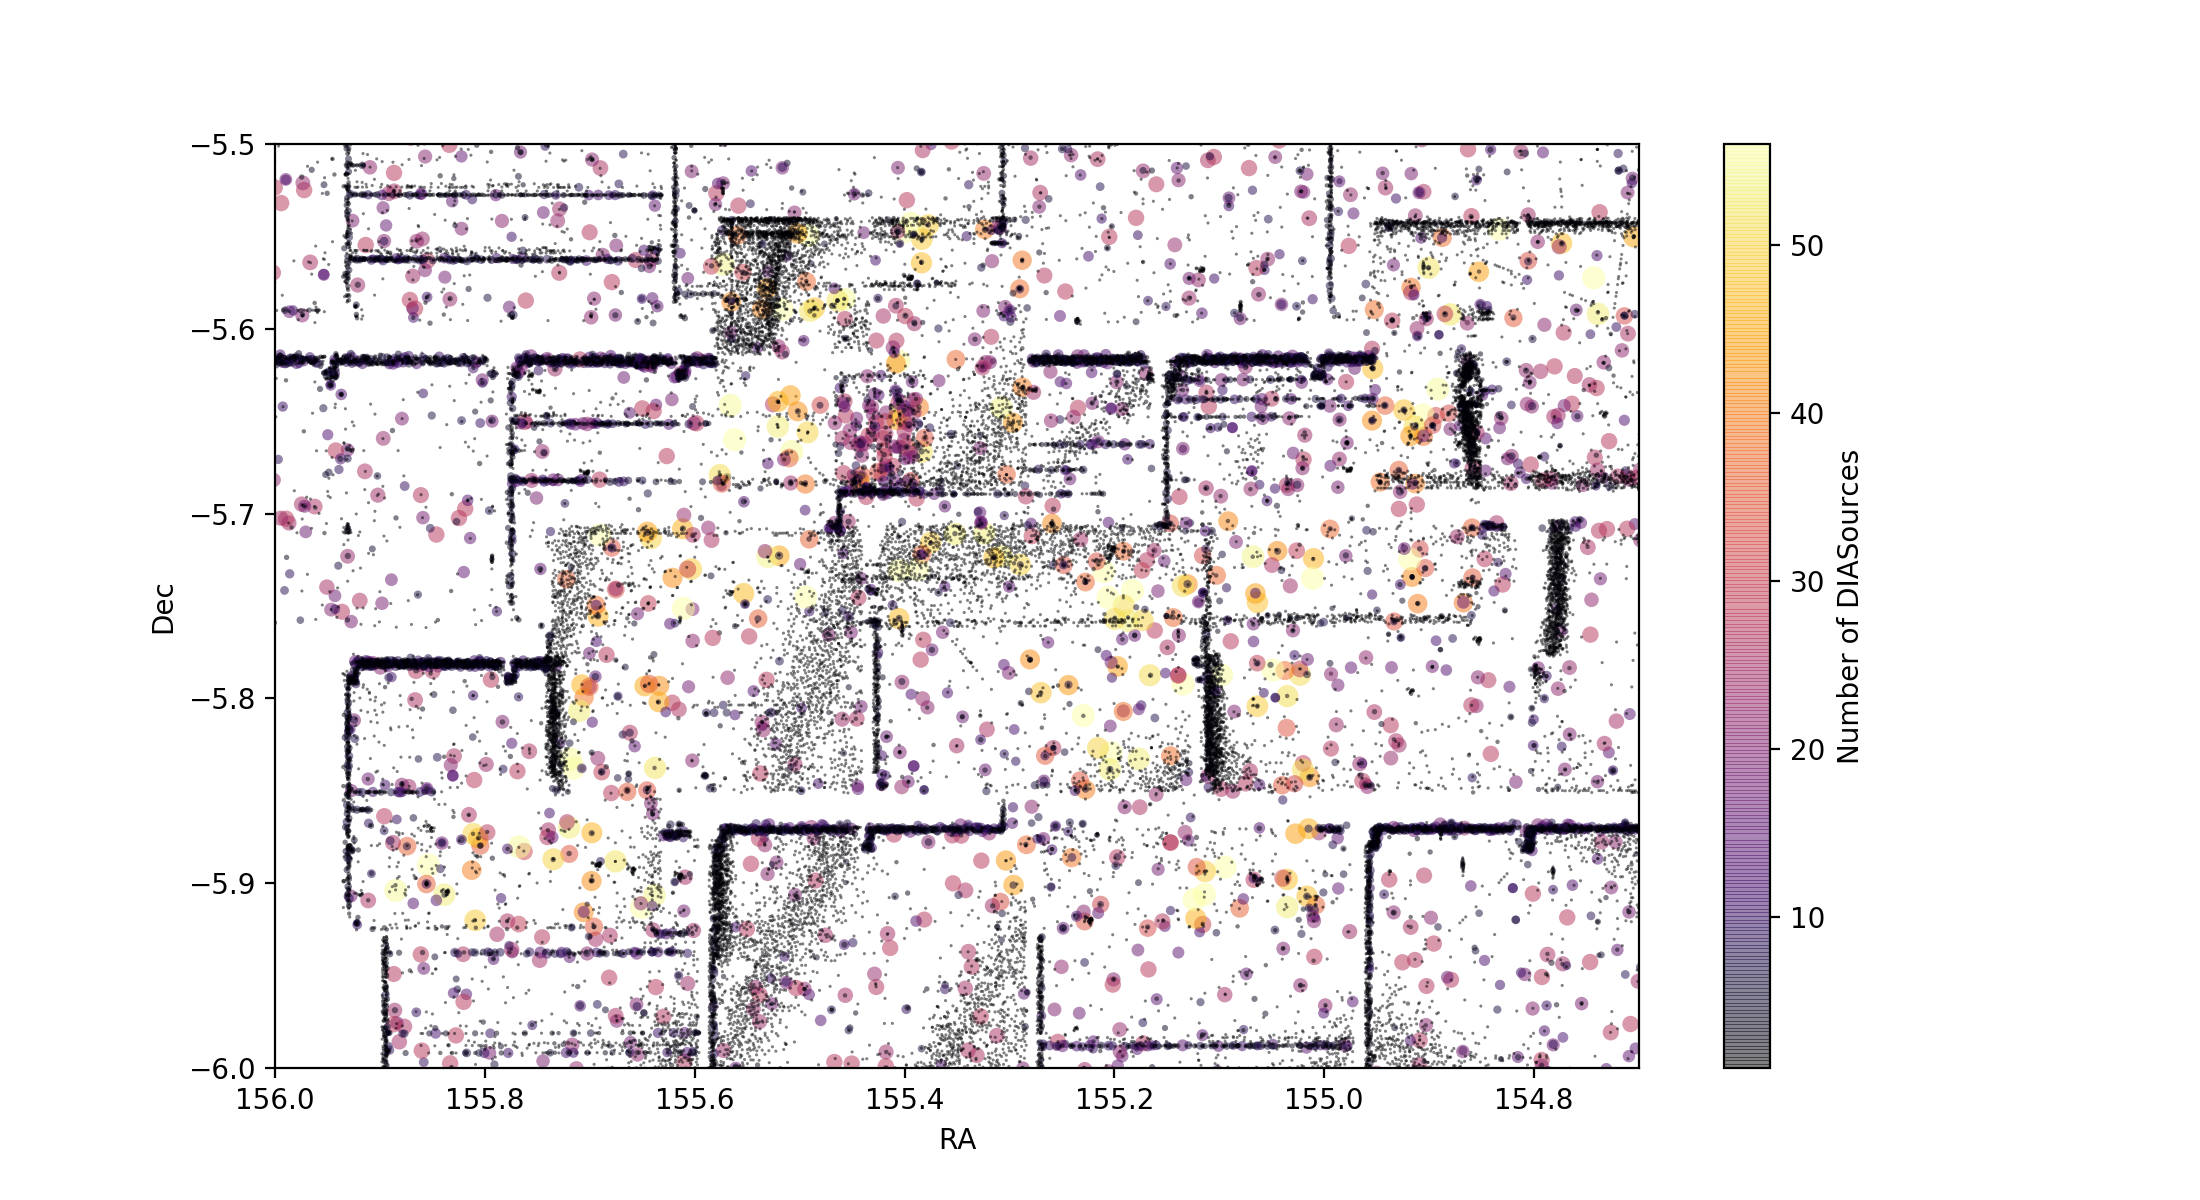

(-6.0, -5.5)

In [9]:
fig = plt.figure(facecolor='white', figsize=(11,6))
ax1 = fig.add_subplot(111)
cb1 = ax1.scatter(objTable.loc[dec_set2, 'coord_ra'], objTable.loc[dec_set2, 'coord_dec'], marker='.',
                  lw=0, s=objTable.loc[dec_set2, 'nDiaSources']*5, c=objTable.loc[dec_set2, 'nDiaSources'],
                  alpha=0.5, cmap=plt.cm.get_cmap('inferno'))
cbplot = plt.colorbar(cb1, ax=ax1)
cbplot.set_label('Number of DIASources')

plt.xlabel('RA')
plt.ylabel('Dec')
plt.xlim([156, 154.7])
plt.ylim([-6.0, -5.5])

## Revisiting the CI region

In [10]:
ci_visits = [41137156, 41137160, 41142005, 41142010, 41980205, 41980210]

ci_objects = []
ci_sources = []
for ci_visit in ci_visits:
    ci_objects.extend(srcTable.loc[srcTable['ccdVisitId'] == ci_visit, 'diaObjectId'].values)
    ci_sources.extend(srcTable.loc[srcTable['ccdVisitId'] == ci_visit, 'id'].values)
    
objTable.set_index('id', inplace=True)  # ONLY DO THIS ONCE
srcTable.set_index('id', inplace=True)  # ONLY DO THIS ONCE

In [11]:
all_src_count = objTable.loc[ci_objects, 'nDiaSources']

from collections import Counter
ci_src_count = list(Counter(ci_objects).values())

colors = []
for count in ci_src_count:
    if count == 1:
        colors.append('0.5')
    elif count == 2:
        colors.append('C0')
    elif count == 3:
        colors.append('C1')
    else:
        colors.append('C2')
        print(count)

<IPython.core.display.Javascript object>


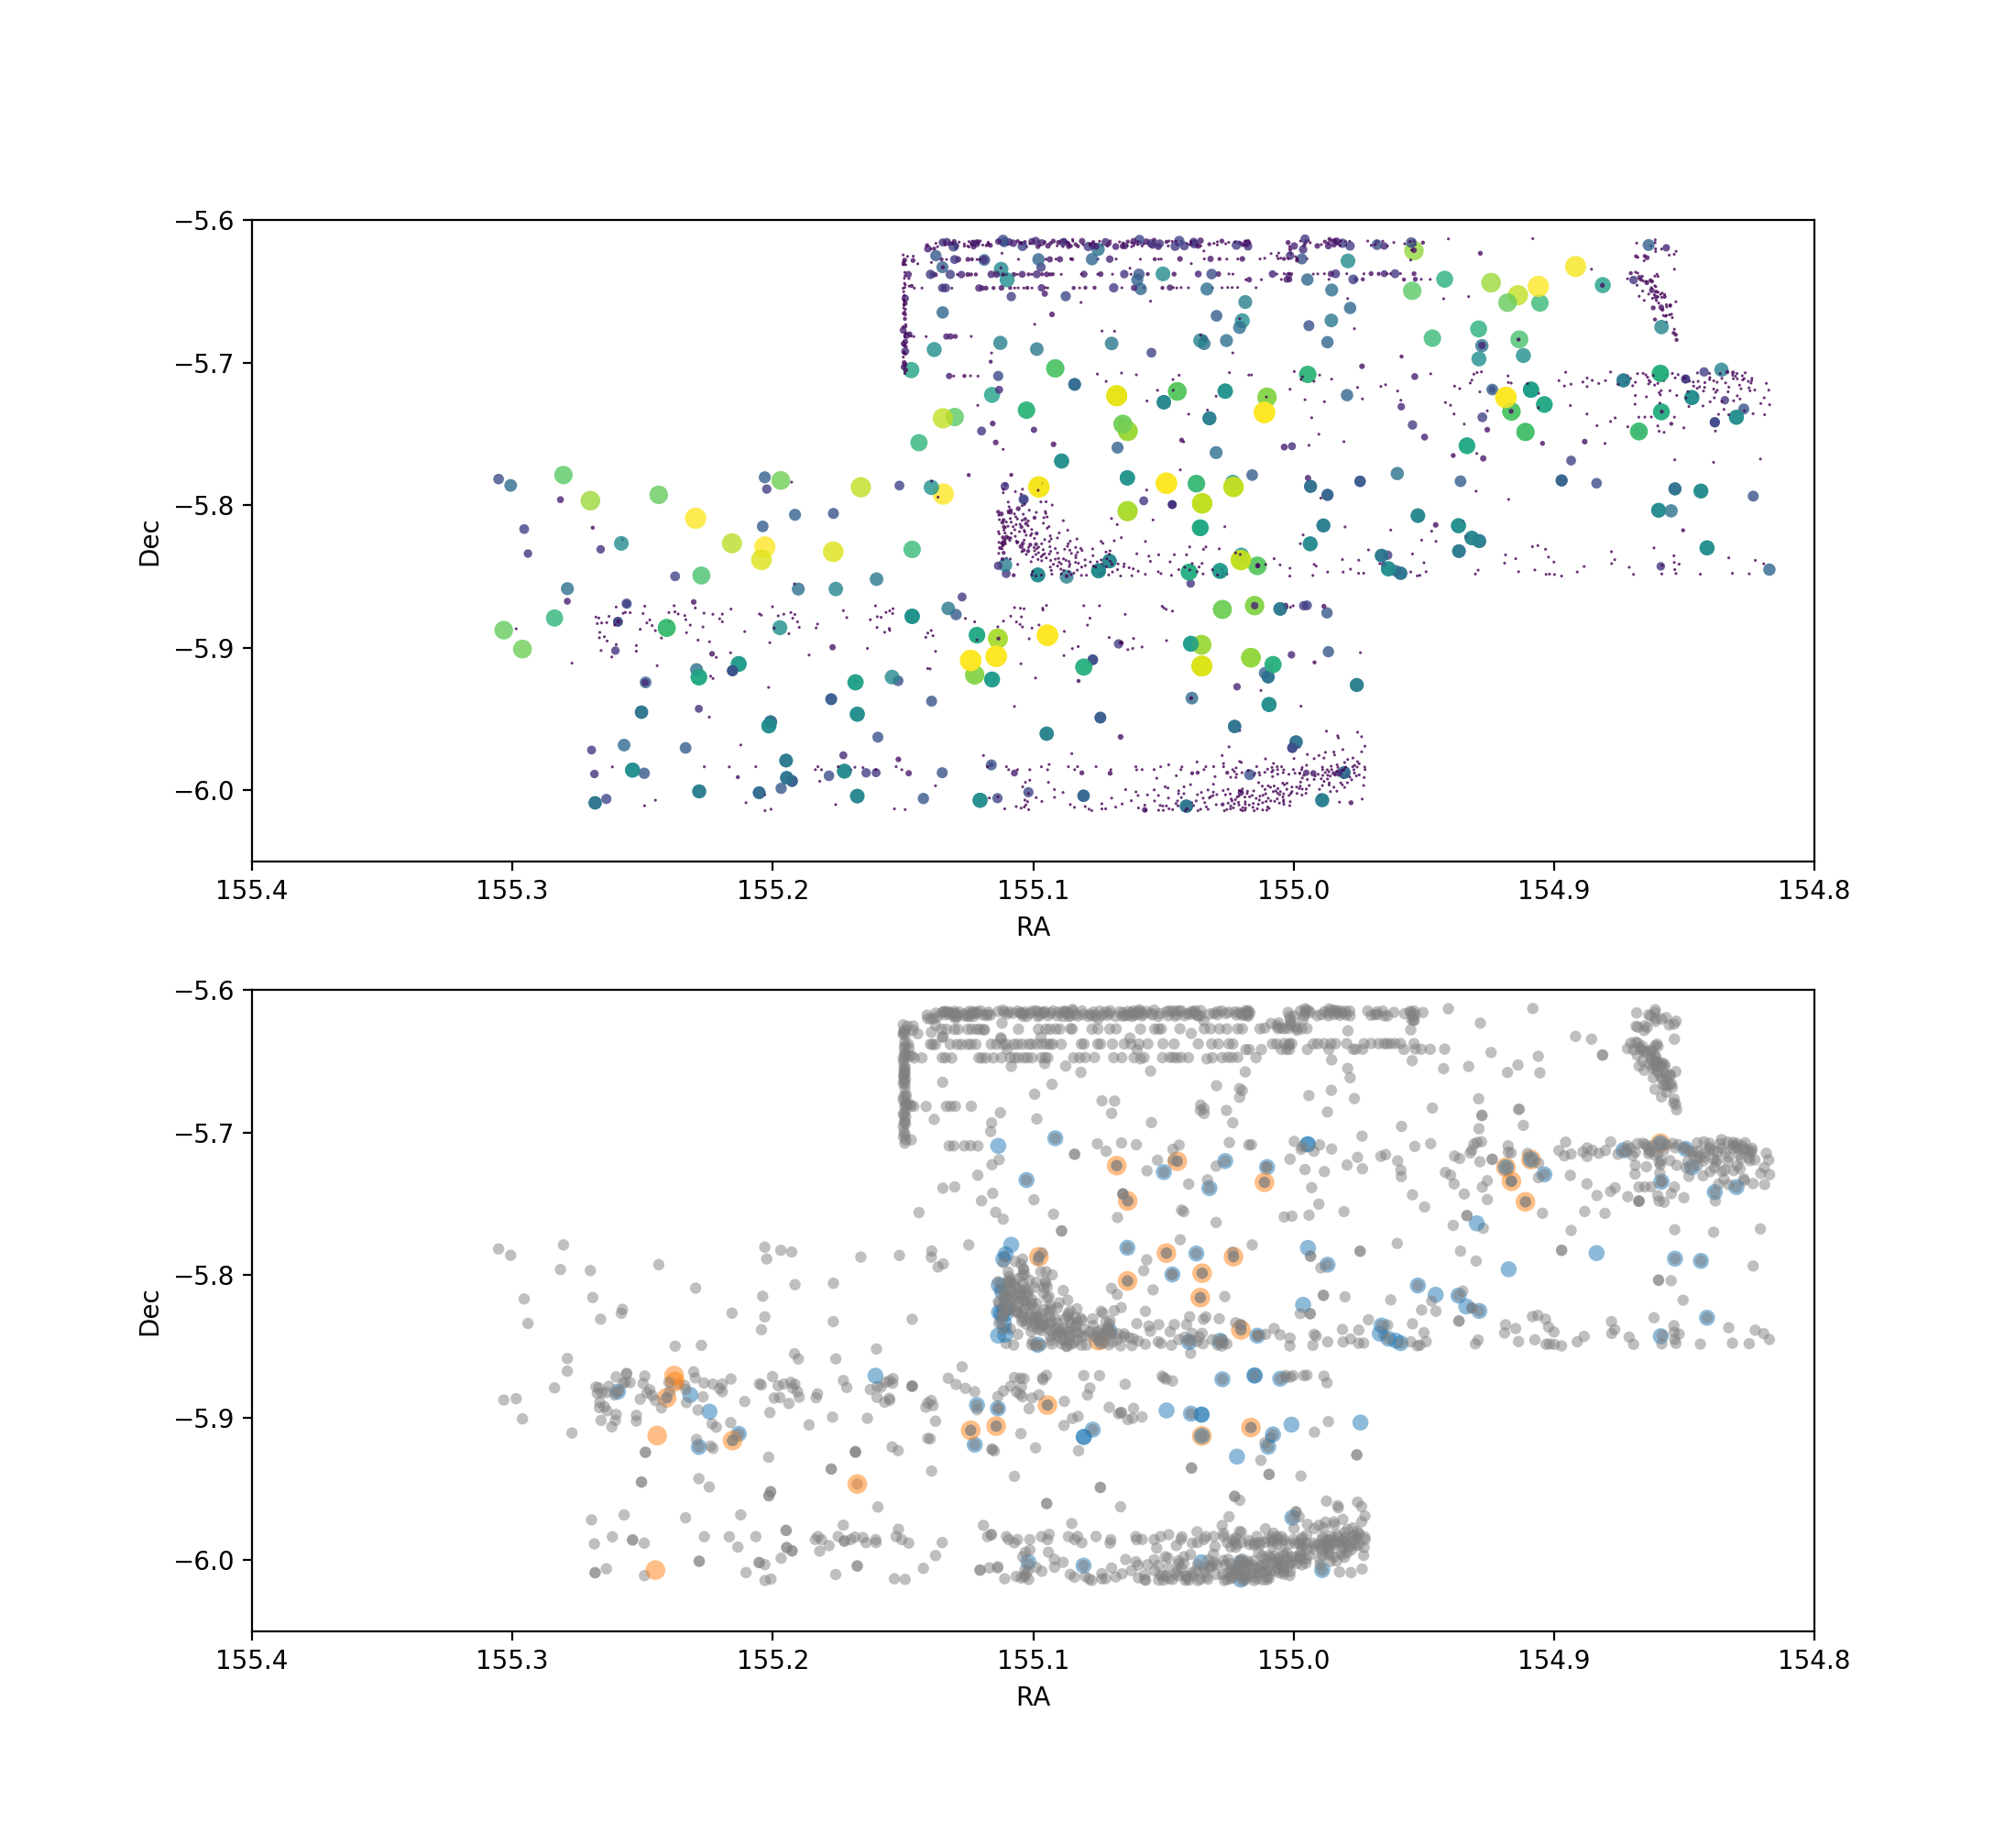

(-6.05, -5.6)

In [12]:
fig2 = plt.figure(facecolor='white', figsize=(11,10))
ax2 = fig2.add_subplot(211)

all_visits = ax2.scatter(objTable.loc[ci_objects, 'coord_ra'], objTable.loc[ci_objects, 'coord_dec'],
                         marker='.', lw=0, alpha=0.8, c=all_src_count, s=all_src_count*5)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.xlim([155.4, 154.8])
plt.ylim([-6.05, -5.6])

ax3 = fig2.add_subplot(212)
ci_visits = ax3.scatter(objTable.loc[ci_objects, 'coord_ra'].values, objTable.loc[ci_objects, 'coord_dec'].values,
                        marker='o', lw=0, alpha=0.5, s=[x*20 for x in ci_src_count], c=colors)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.xlim([155.4, 154.8])
plt.ylim([-6.05, -5.6])